<a href="https://colab.research.google.com/github/LeeSeungwon89/Machine-learning_Theory/blob/master/CHAPTER4%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%ED%91%9C%ED%98%84%EA%B3%BC%20%ED%8A%B9%EC%84%B1%20%EA%B3%B5%ED%95%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 들어가며

2차원 실수형 배열을 가진 데이터로서 각 열이 샘플에 대해 설명하면 연속형 특성(continuous feature)이라고 가정했습니다. 하지만 많은 애플리케이션에서는 이렇게 데이터가 수집되지 않습니다. 일반적인 특성의 전형적인 형태는 숫자 값이 아닌 범주형 특성(categorical feature)(=이산형 특성(discrete feature))입니다.

연속형 특성과 범주형 특성은 회귀와 분류의 차이와 비슷합니다. 다만 출력이 아닌 입력에 대한 것이란 점에서 차이가 있습니다. 앞서 살폈던 연속형 특성의 예는 픽셀 밝기, 붓꽃 측정값입니다. 범주형 특성의 예는 제품 브랜드, 색상, 판매 분류(책, 옷, 하드웨어) 등입니다. 이런 특성들은 모두 상품을 묘사하는 속성이므로 연속된 값이 아닙니다. 제품과 제품 간에는 중간값이 없고 순서도 없습니다.

하지만 데이터의 특성이 어떤 형태를 취하는지보다 중요한 것은 데이터를 표현하는 방식입니다. 이 방식에 따라 머신러닝 모델 성능에 주는 영향이 큽니다. 데이터의 스케일을 조정하는 것이 매우 중요하다는 점을 강조했습니다. 예를 들면 측정치의 스케일을 조정하지 않았을 때 센티미터, 인치의 기준에 따라 큰 차이가 생깁니다. 스케일 조정뿐만 아니라 특성의 상호작용(특성 간의 곱)이나 일반적인 다항식을 추가 특성으로 넣는 것도 방법입니다.

특정 애플리케이션에 가장 적합한 데이터 표현을 찾는 것을 '특성 공학(feature engineering)'이라고 합니다. 올바른 데이터 표현을 찾는다면 지도 학습 모델에서 적절한 매개변수를 선택하는 것보다 모델 성능을 더 크게 제고할 수 있습니다.

# 4.1 범주형 변수

예제에 사용할 데이터는 [1994년 인구 조사 데이터베이스에서 추출한 미국 성인의 소득 데이터셋](https://github.com/rickiepark/introduction_to_ml_with_python/blob/master/data/adult.data)입니다. 이 데이터셋을 사용해서 특정 근로자의 수입이 50,000달러를 초과하는지 이하인지를 예측하고자 합니다.

In [67]:
pip install mglearn

In [68]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline

In [69]:
# 데이터셋 10개를 부르기 위한 코드입니다.
# 코드는 뒤에서 다시 설명합니다.
import os

data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'adult.data'),
                   header=None, index_col=False,
                   names=['age', 'workclass', 'fnlwgt', 'education',
                          'education-num', 'marital-status', 'occupation',
                          'relationship', 'race', 'gender', 'capital-gain',
                          'capital-loss', 'hours-per-week', 'native-country',
                          'income'])
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
display(data.head(11))

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K
5,37,Private,Masters,Female,40,Exec-managerial,<=50K
6,49,Private,9th,Female,16,Other-service,<=50K
7,52,Self-emp-not-inc,HS-grad,Male,45,Exec-managerial,>50K
8,31,Private,Masters,Female,50,Prof-specialty,>50K
9,42,Private,Bachelors,Male,40,Exec-managerial,>50K


데이터셋에는 여러 특성이 있습니다. 근로자 나이(age), 고용형태(workclass), 교육수준(education), 성별(gender), 주당 근로시간(hours-per-week), 직업(occupation) 등입니다.

이 예측 작업은 소득(income)이 <=50k, >50k라는 두 클래스를 가진 분류 문제입니다. 정확한 소득을 예측하고자 한다면 회귀 문제입니다.

이 데이터셋에 있는 'age'와 'hours-per-week'는 연속형 특성입니다. 그리고 'workclass', 'education', 'sex', 'occupation'은 범주형 특성입니다. 범위가 아닌 고정된 목록 중에 하나를 값으로 가지며 정성적(qualitative)입니다.

먼저 로지스틱 회귀 분류기를 학습시킵니다. 공식을 다시 서술하면 아래와 같습니다. 

$\hat{y}=w[0] \times x[0] + w[1] \times x[1] + \cdots +w[p] \times x[p] + b > 0$

$w[i]$와 $b$는 훈련 세트로부터 학습되는 계수이고 $x[i]$는 입력 특성입니다. $x[i]$는 숫자여야 하므로 $x[2]$는 'masters'나 'Bachelors'가 될 수 없습니다. 따라서 로지스틱 회귀를 사용하려면 데이터를 다른 방식으로 표현해야 합니다.

## 4.1.1 원-핫-인코딩(가변수)

범주형 변수를 표현하는 데 가장 널리 쓰이는 방법은 '원-핫-인코딩(one-hot encoding)'입니다. '원-아웃-오브-엔 인코딩(one-out-of-N encoding)', '가변수(dummy variable)'로도 불립니다. 가변수는 범주형 변수를 0 또는 1인 값을 가진 하나 이상의 새로운 특성으로 바꾼 것입니다. 이렇게 0과 1로 표현된 변수를 선형 이진 분류 공식에(모든 모델에) 적용할 수 있습니다. 

0과 1로 표현된 변수는 개수와 상관없이 범주마다 특성 하나로 표현합니다. 가령 'workclass' 특성에 클래스 네 가지가 존재한다면, 이 클래스 네 가지를 인코딩 하기 위해 새로운 특성 네 가지를 만듭니다. 어떤 사람의 'workclass' 값에 해당하는 특성은 1이고 나머지 세 특성은 0이 되는 식입니다. 다시 말하면 샘플마다 새로운 특성 하나만 1을 갖고 나머지 특성은 0입니다. 원핫, 원아웃오브엔이 의미하는 바입니다.

참고로 원-핫 인코딩은 통계학에서 사용하는 '더미 코딩'과 유사하지만 차이점이 존재합니다. 머신러닝에서는 특성의 범주를 각기 다른 이진 특성으로 바꾸지만, 통계학에서는 k개의 값을 가진 범주형 특성을 k-1개의 특성으로 변환하는 것이 일반적입니다. 데이터 행렬의 '랭크 부족(rank deficient)' 현상을 피할 목적입니다. 랭크 부족에 대해서 더 설명하자면, 열 랭크 부족(column rank deficient)은 범주 네 개를 특성 네 개로 인코딩 하면 맨 마지막 특성은 앞의 세 특성을 참조해서 예측할 수 있고, 한 열이 다른 열에 의존적이거나 열의 값이 모두 0인 경우를 뜻합니다. 행렬 분해 방식에 따라서 문제가 될 소지가 있으나 사이킷런에서는 이런 문제를 일으키지 않습니다.

판다스나 사이킷런을 사용해서 범주형 변수를 원-핫-인코딩으로 바꿀 수 있습니다. 먼저 판다스를 사용해서 `csv` 파일을 읽습니다.

In [70]:
# 이 파일은 열 이름을 나타내는 헤더가 없으므로 `header=None`으로 지정합니다.
# 열 이름을 지정하고자 `names` 매개변수에 리스트 형태의 값을 넣습니다.
data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'adult.data'),
                   header=None, index_col=False,
                   names=['age', 'workclass', 'fnlwgt', 'education',
                          'education-num', 'marital-status', 'occupation',
                          'relationship', 'race', 'gender', 'capital-gain',
                          'capital-loss', 'hours-per-week', 'native-country',
                          'income'])
# 지정한 열의 값만 불러옵니다.
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
print(data)
display(data.head())

       age          workclass  ...          occupation  income
0       39          State-gov  ...        Adm-clerical   <=50K
1       50   Self-emp-not-inc  ...     Exec-managerial   <=50K
2       38            Private  ...   Handlers-cleaners   <=50K
3       53            Private  ...   Handlers-cleaners   <=50K
4       28            Private  ...      Prof-specialty   <=50K
...    ...                ...  ...                 ...     ...
32556   27            Private  ...        Tech-support   <=50K
32557   40            Private  ...   Machine-op-inspct    >50K
32558   58            Private  ...        Adm-clerical   <=50K
32559   22            Private  ...        Adm-clerical   <=50K
32560   52       Self-emp-inc  ...     Exec-managerial    >50K

[32561 rows x 7 columns]


,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


### 범주형 데이터 문자열 확인하기

데이터셋을 읽은 후에는 먼저 범주형 데이터를 유심히 살피는 것이 현명합니다. 정해진 범주를 벗어난 값이 있을 수도 있고, 철자나 대소문자가 틀린 값이 있을 수도 있으므로 반드시 데이터를 전처리해야 합니다. 예컨대 남성이 'man'으로 입력되지 않고 'male'로 입력됐다면 이 값들은 필시 같은 범주로 인식하도록 조치해야 합니다. 

열의 내용을 확인하려면 판다스에서 (데이터프레임(DataFrame)의 열을 나타내는)Series에 있는 `value_counts` 메서드를 사용합니다. 유일한 값이 몇 번씩 출력되는지 확인할 수 있습니다. 실제로는 모든 열의 값을 살펴야 하지만 여기에서는 'gender' 열의 값만 확인합니다.

In [71]:
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


두 가지 값만을 가지고 있습니다. 원-핫-인코딩으로 나타내기에 적합합니다.

판다스에서는 `get_dummies` 함수를 사용해서 문자열과 같은 객체 타입 특성이나 범주형(R의 factor와 유사한 판다스의 category를 의미합니다) 특성을 가진 열을 자동으로 변환합니다. 각 특성을 펼쳐서 생성하는 것입니다.

In [72]:
print('원본 특성:\n', list(data.columns), '\n')
data_dummies = pd.get_dummies(data)
print('get_dummies를 사용한 후의 특성:', list(data_dummies.columns))

원본 특성:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

get_dummies를 사용한 후의 특성: ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupati

In [73]:
display(data_dummies.head())

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,gender_ Female,gender_ Male,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,50,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,38,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,53,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,28,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


연속형 특성인 'age'와 'hours-per-week'는 그대로지만 범주형 특성은 새로운 특성으로 확장되고 생성됐습니다.

`get_dummies` 함수의 `values` 속성을 사용해서 판다스 데이터프레임을 넘파이 배열로 바꿀 수 있습니다. 이렇게 바꾼 넘파이 배열로 머신러닝 모델을 학습시킬 수 있습니다.

위에서 서술했듯이 이 문제의 주제는 특정 근로자의 수입이 50,000달러를 초과하는지 아닌지를 예측하는 것입니다. 따라서 'income'을 타깃값으로 삼을 예정입니다. 먼저 모델을 학습시키기 전에 'income'으로 시작하는 두 열에 인코딩 된 타깃값을 분리해야 합니다. 출력값이나 출력값으로부터 유도된 변수를 특성 표현에 포함하는 것은 지도 학습 모델을 만들 때 저지르기 쉬운 실수입니다. 여하튼 특성을 포함한 열, 즉 'age'부터 'occupation_ Transport-moving'까지 모든 열을 추출합니다. 타깃값인 'income'을 뺀 모든 특성입니다.

참고로 이 예제에서는 타깃값도 원-핫-인코딩을 통해 0과 1로 변환했지만 사실 사이킷런에서는 문자열도 타깃값으로 사용할 수 있습니다. 'income' 열을 그대로 사용해도 괜찮습니다.

In [74]:
# 판다스에서 열 인덱싱은 넘파이와는 다르게 범위의 끝을 포함합니다.
# 'age' 열부터 'occupation_ Transport-moving' 열까지 포함하는 것입니다.
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']
print(features)
# 넘파이 배열을 추출합니다.
X = features.values
print(X)
# 타깃값으로 삼을 'income' 열을 y로 지정합니다.
y = data_dummies['income_ >50K'].values
print(y)
print('X.shape: {} y.shape: {}'.format(X.shape, y.shape))

       age  ...  occupation_ Transport-moving
0       39  ...                             0
1       50  ...                             0
2       38  ...                             0
3       53  ...                             0
4       28  ...                             0
...    ...  ...                           ...
32556   27  ...                             0
32557   40  ...                             0
32558   58  ...                             0
32559   22  ...                             0
32560   52  ...                             0

[32561 rows x 44 columns]
[[39 40  0 ...  0  0  0]
 [50 13  0 ...  0  0  0]
 [38 40  0 ...  0  0  0]
 ...
 [58 40  0 ...  0  0  0]
 [22 20  0 ...  0  0  0]
 [52 40  0 ...  0  0  0]]
[0 0 0 ... 0 0 1]
X.shape: (32561, 44) y.shape: (32561,)


사이킷런에서 사용할 수 있는 형태가 됐습니다. `LogisticRegression`을 적용해서 점수를 출력합니다.

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
print('테스트 점수: {:.2f}'.format(logreg.score(X_test, y_test)))

테스트 점수: 0.81


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**CAUTION**

본서에서 매우 중요한 내용을 CAUTION이라는 파트에서 설명하고 있습니다. 이 내용을 자세하게 서술합니다.

이 데이터프레임에는 훈련 데이터와 테스트 데이터가 모두 담겨 있습니다. 훈련 세트와 테스트 세트를 `get_dummies` 함수를 사용해서 범주형 값을 같게 만들었습니다.

훈련 세트와 테스트 세트가 서로 다른 데이터프레임 형태를 가지고 있다고 가정하겠습니다. 'workclass' 특성의 'Private Employee' 값이 테스트 세트에 없으면 판다스는 이 특성의 값이 세 개뿐이라고 판단하고 세 개의 가변수 특성을 만듭니다. 그러면 훈련 세트와 테스트 세트의 특성 개수가 달라집니다. 훈련 세트에서 학습된 모델을 테스트 세트에 적용할 수 없게 되는 것입니다.

더 심각하게 'workclass' 특성이 훈련 세트는 'Government Employee'와 'Private Employee'를 가지고, 테스트 세트는 'Self Employed'와 'Self Employed incorperated'를 가진다고 가정하면, 판다스는 양쪽 모두 두 개의 다른 새로운 가변수 특성을 추가하게 됩니다. 그렇게 만들어진 두 데이터프레임의 특성 개수는 일단 같게 되지만, 가변수 특성 두 개는 훈련 세트와 테스트 세트에서 완전히 다른 의미를 지닙니다. 훈련 세트의 'Government Employee' 특성을 나타내는 열은 테스트 세트의 'Self Employed' 특성을 의미하는 것입니다. 이렇게 매우 다른 의미의 두 열을 단지 위치가 같다는 이유만으로 같은 것으로 여기기 때문에 이런 데이터로 모델을 만들면 결코 좋지 못한 결과를 얻습니다.

이를 방지하려면 위에서 제시한 예시 데이터처럼 훈련 데이터와 테스트 데이터 모두를 포함한 데이터프레임으로 `get_dummies` 함수를 호출하거나, 각각 `get_dummies` 함수를 호출해서 훈련 세트와 테스트 세트의 열 이름을 비교해서 같은 속성인지 확인해야 합니다.

## 4.1.2 숫자로 표현된 범주형 특성

adult 데이터셋은 범주형 변수가 문자열로 인코딩 되어 있습니다. 철자에 오류가 있을 수 있지만 범주형 변수라는 점을 분명하게 나타냅니다. 하지만 저장 공간을 절약하거나 데이터 취합 방식에 따라 이 변수가 숫자로 인코딩 된 경우가 많습니다. 예를 들면 adult 데이터셋에 있는 인구조사 데이터를 설문지를 사용해서 수집했다고 가정한다면 'workclass'에 대한 질문의 대답은 값(8개)을 나타내는 체크 박스의 순서에 따라 0에서 8이 부여됩니다. 문자열인 'Private'가 숫자로 표현되는 것입니다. 이런 형태를 연속형인지 범주형인지 쉽게 알기는 어렵습니다. 다만 'workclass'의 값을 숫자(이산적)로 나타냈다는 사실을 인지한다면 연속형 변수로 다루지 않아야 한다는 점을 명확하게 깨달을 수 있습니다.

**CAUTION**

범주형 특성은 종종 숫자로 인코딩 되므로 무조건 연속형 특성으로 다뤄서는 안 됩니다. 숫자로 이루어진 특성이 연속형인지 이산형인지 원-핫-인코딩 된 것인지는 항상 명확하게 구분할 수 없습니다. 다만 인코딩 된 값 사이에 어떤 순서도 존재하지 않다면 이산형으로 추론할 수 있습니다. 예를 들어 별 다섯 개가 만점인 평점 데이터의 경우라면 문제나 데이터, 어떤 머신러닝 알고리즘을 사용하느냐에 따라 적절한 인코딩 방법을 선택합니다. 물론 보통의 경우는 별의 개수에 따라 평점이 분류되므로 범주형으로 다루지만, 별점에 대한 평균을 구할 목적이라면 연속형으로 다룹니다. 영화 관람 등급의 경우처럼 순서를 가진 범주형 속성도 있습니다. 다양한 관점으로 데이터를 살펴볼 필요가 있습니다.

`get_dummies` 함수는 숫자 특성을 무조건 연속형으로 간주해서 가변수를 생성하지 않습니다. 이를 설명하기 위해 숫자 특성과 범주형 문자열 특성을 가진 데이터프레임의 객체를 만듭니다.

In [76]:
demo_df = pd.DataFrame({'number_features': [0, 1, 2, 1],
                        'categorical_features': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

,number_features,categorical_features
0,0,socks
1,1,fox
2,2,socks
3,1,box


'socks'는 숫자 특성이 동일하게 0이 아니라 각각 0과 2를 가졌습니다.

`get_dummies` 함수를 사용해서 결과를 확인합니다.

In [77]:
display(pd.get_dummies(demo_df))

,number_features,categorical_features_box,categorical_features_fox,categorical_features_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


문자열 특성만 인코딩 되고 숫자 특성은 바뀌지 않았습니다.

만약 숫자로 된 특성도 가변수로 만든다면 `columns` 매개변수에 인코딩 하고자 하는 열을 명시합니다. 이렇게 하면 모든 특성을 범주형으로 간주합니다. 

In [78]:
demo_df['number_features'] = demo_df['number_features'].astype(str)
display(pd.get_dummies(demo_df, columns=['number_features', 'categorical_features']))

,number_features_0,number_features_1,number_features_2,categorical_features_box,categorical_features_fox,categorical_features_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


물론 `demo_df['number_features'].astype(str)` 형식으로 숫자를 문자열로 바꾸면 `columns` 매개변수에 값을 지정하지 않아도 가변수 특성이 만들어집니다. 위 코드에서 제시한 두 방법 중에 하나만 택해도 충분합니다.

# 4.2 OneHotEncoder와 ColumnTransformer: scikit-learn으로 범주형 변수 다루기

원-핫-인코딩은 `OneHotEncoder` 클래스에 구현되어 있습니다. 이 클래스로 모든 열에 인코딩 할 수 있습니다.

In [79]:
from sklearn.preprocessing import OneHotEncoder
# `Sparse` 매개변수에 `False` 값을 지정하면 넘파이 배열을 반환합니다.
# 'True` 값은 희소행렬을 반환합니다.
ohe = OneHotEncoder(sparse=False)
print(ohe.fit_transform(demo_df))

[[1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0.]]


문자열 특성과 정수 특성이 모두 변환됐습니다.

`get_feature_names` 메서드를 사용하면 원본 범주형 변수 이름을 얻습니다.

In [80]:
print(ohe.get_feature_names())

['x0_0' 'x0_1' 'x0_2' 'x1_box' 'x1_fox' 'x1_socks']


'x0_0', 'x0_1', 'x0_2' 열은 원본 특성인 0, 1, 2입니다. 'x1_box', 'x1_fox', 'x1_socks' 열은 두 번째 원본 특성인 'box', 'fox', 'socks'입니다.

데이터 대부분은 범주형 특성과 연속형 특성이 섞여있습니다. `OneHotEncoding` 클래스는 모든 특성을 범주형으로 간주하므로, `ColumnTransformer` 클래스를 사용해서 입력 데이터의 열마다 다른 변환을 적용해야 합니다. 범주형 특성과 연속형 특성은 전처리 하는 과정이 다르므로 `ColumnTransformer` 클래스를 사용하여 수월하게 전처리 할 수 있습니다.

adult 데이터셋을 다시 사용합니다. 데이터셋의 일부분을 출력합니다.

In [81]:
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


이 데이터셋에 선형 모델을 적용해서 소득을 예측하려면 범주형 변수에 대한 원-핫-인코딩뿐만 아니라 연속형 변수인 'age'와 'hours-per-week'의 스케일도 조정해야 합니다. 이를 위해 `ColumsTransformer` 클래스를 사용합니다.

In [82]:
from sklearn.compose import ColumnTransformer
# 스케일을 조정하는 클래스인 `StandardScaler`를 부릅니다.
from sklearn.preprocessing import StandardScaler

# `ColumnTransformer` 클래스의 사용법입니다.
# 이름, 변환기 객체, 변환이 적용될 열 차례로 지정합니다.
# 열은 열 이름이나 정수 인덱스, 불리언 마스크(넘파이 배열의 경우)로 선택합니다.
# 열이 변환되면 변환 결과는 나란히 합쳐집니다.
# 혼동을 피하고자 코드를 길게 늘어뜨렸습니다.
ct = ColumnTransformer(
    [('Scaling', StandardScaler(), ['age', 'hours-per-week']),
     ('onehot', OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation'])])

`ColumnTransformer` 클래스도 `fit`과 `transform` 메서드를 가집니다. 다음 코드에서 이 메서드들을 사용하여 선형 모델을 생성합니다. 이번에는 연속형 변수의 스케일을 조정합니다. `train_test_split` 함수에 데이터프레임도 전달할 수 있습니다. 열 이름은 `ColumnTransformer` 클래스에 필요하므로 보존합니다.

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# 'income' 열을 제외하고 모든 열을 추출합니다.
# 'data_features'는 데이터프레임입니다.
data_features = data.drop('income', axis=1)
# `train_test_split` 함수로 데이터프레임과 `income` 열(타깃값)을 분할합니다.
# 'data_features'는 데이터프레임이므로
# 'X_train', 'X_test'도 데이터프레임입니다.
# 'y_train', 'y_test', 'data.income' 또한
# (데이터프레임(DataFrame)의 열을 나타내는)Series 객체입니다.
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data.income, random_state=0)
# `ColumnTransformer` 클래스에 훈련 데이터를 넣고 훈련시킵니다.
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)

(24420, 44)


`pd.get_dummies` 함수를 사용한 경우처럼 특성 44개가 생성됐습니다. 연속형 특성의 스케일을 조정했다는 점만 다릅니다. 이를 토대로 `LogisticRegression` 모델을 만듭니다.

In [84]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_trans, y_train)

X_test_trans = ct.transform(X_test)
print('테스트 점수: {:.2f}'.format(logreg.score(X_test_trans, y_test)))

테스트 점수: 0.81


위에서 출력했던 테스트 점수인 0.81과 같은 결괏값입니다. 데이터 스케일이 영향을 미치지 못했다고 볼 수 있습니다.

`named_transformers_` 속성을 사용하여 `ColumnTransformer` 클래스의 단계를 확인합니다.

In [85]:
print(ct.named_transformers_.Scaling)
print(ct.named_transformers_.onehot)

StandardScaler(copy=True, with_mean=True, with_std=True)
OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)


# 4.3 make_column_transformer로 간편하게 ColumnTransformer 만들기

앞에서 설명한 방법대로 `ColumnTransformer`를 만들 때 각 단계 이름을 일일이 지정할 필요가 없는 경우가 많습니다. 이 경우에는 `make_column_transformer` 함수를 사용해서 자동으로 각 단계에 이름을 붙여주면 편리합니다.

`make_column_transformer` 함수를 사용하는 방법을 살핍니다.

In [86]:
from sklearn.compose import make_column_transformer

ct = make_column_transformer(
    (StandardScaler(), ['age', 'hours-per-week']),
    (OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation']))

# 4,4 구간 분할, 이산화 그리고 선형 모델, 트리 모델

데이터를 잘 표현하는 방법은 데이터가 가진 의미뿐 아니라 어떤 모델을 사용하는지에 따라 다릅니다. 많이 사용하는 선형 모델과 트리 기반 모델들은 특성의 표현 방식으로 미치는 영향이 매우 다릅니다.

2장에서 사용했던 wave 데이터셋으로 선형 회귀 모델과 결정 트리 회귀를 비교합니다. 이 데이터에는 입력 특성이 하나입니다.

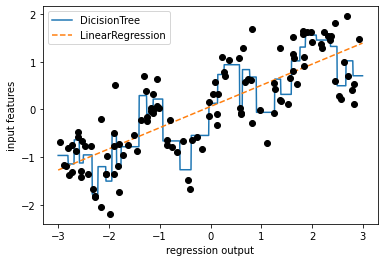

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label='DicisionTree')

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), '--', label='LinearRegression')

plt.plot(X[:, 0], y, 'o', c='k')
plt.xlabel('regression output')
plt.ylabel('input features')
plt.legend(loc='best')

선형 모델은 선형 관계로만 모델링을 하므로 특성이 하나일 땐 직선 형태입니다. 결정 트리는 데이터로 훨씬 복잡한 모델을 만들 수 있습니다. 그러나 데이터의 표현 형태에 따라 굉장히 달라집니다.

연속형 데이터에 아주 강력한 선형 모델을 만드는 방법 중에 하나는 한 특성을 여러 특성으로 나누는 '구간 분할(bining)(=이산화)'입니다. 만약 이 특성의 입력값 범위(-3~3)가 나뉘어 10개 구간으로 되어있다고 가정하면, 각 샘플이 속하는 해당 구간을 나타낼 수 있습니다. 

구간의 경계를 정의하는 여러 방법이 존재합니다. 예컨대 구간의 경계 간의 거리를 같게 하거나 데이터의 분위를 사용할 수 있습니다. 데이터가 많은 구간은 좁습니다. `KBinsDiscretizer` 클래스에 이 방법들이 구현되어 있습니다.

In [88]:
from sklearn.preprocessing import KBinsDiscretizer

# `n_bins` 매개변수에 10을 지정하여 구간 10개를 만듭니다.
kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
kb.fit(X)
# `bin_edges_` 속성에는 특성별 경계값이 (리스트가 아닌)1차원 넘파이 배열로 저장되어 있습니다.
print('bin edges: \n', kb.bin_edges_)

bin edges: 
 [array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
       -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
        2.92132162])]


값이 11개가 출력됐습니다. 10개 특성의 사이값을 나타내므로 1개가 더 출력된 것입니다. 첫 번째 구간에는 특성 값이 -2.967~-2.378인 모든 샘플이 위치합니다. 이런식으로 모든 구간의 값에 해당하는 샘플들이 위치합니다. 

`transform` 메서드를 사용하면 각 샘플을 해당되는 구간으로 인코딩 합니다. `KBinsDiscretizer` 클래스는 기본적으로 구간에 원-핫-인코딩을 적용합니다. 구간마다 새로운 특성 하나가 생기므로 희소 행렬을 만듭니다. 구간 10개를 지정했으므로 변환된 데이터는 특성이 10개인 10차원입니다.

In [89]:
X_binned = kb.transform(X)
X_binned

<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 120 stored elements in Compressed Sparse Row format>

희소 행렬을 밀집 배열로 변환해서 원본 샘플과 인코딩 결과를 비교합니다.

In [90]:
print(X[:10])
X_binned.toarray()[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

첫 번째 샘플은 네 번째 구간에 들어갔고, 두 번째 샘플은 열 번째 구간에 들어갔습니다. 이렇게 지속됩니다.

wave 데이터셋의 연속형 특성을 구간에 각 샘플이 속하게 하여 원-핫-인코딩 한 범주형 특성으로 변환했습니다. `encode='ordinal'`로 설정하면 원-핫-인코딩 된 구간의 인덱스를 바로 계산할 수 있지만 유용하지는 않습니다.

예제를 간단하게 만들기 위해 `encode='onehot-dense'`로 지정해서 원-핫-인코딩 된 밀집 배열을 만듭니다. 이 방법을 통해 모든 특성을 바로 출력할 수 있게 됩니다.

In [91]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

원-핫-인코딩 된 데이터로 선형 회귀 모델과 결정 트리 모델을 새로 만듭니다.

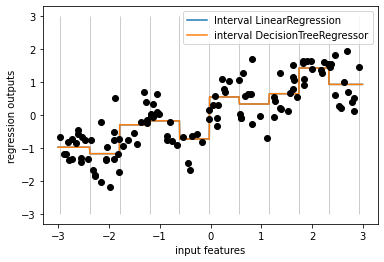

In [92]:
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='Interval LinearRegression')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='interval DecisionTreeRegressor')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

두 모델이 같은 예측을 만들면서 두 종류의 선이 겹쳐졌습니다. 구간별로 두 모델이 예측한 값은 상숫값입니다. 각 구간 안에서는 특성 값이 상수이므로 어떤 모델이든 그 구간의 샘플에 대해서는 같은 값을 예측할 것입니다.

구간으로 나눈 특성을 사용하기 전과 비교하면 각 구간에서 다른 값을 가졌으므로 선형 모델이 훨씬 유연해진 것을 확인할 수 있습니다. 일부 특성과 출력은 비선형 관계에 있지만 용량이 매우 큰 고차원 데이터셋에 선형 모델을 사용한다면 구간 분할을 통해 모델 성능을 제고할 수 있습니다.

결정 트리 모델은 비교적 덜 유연해졌습니다. 결정 트리는 데이터셋에서 예측을 위한 가장 좋은 구간을 학습하고, 한 번에 여러 특성을 살필 수 있습니다. 다시 말하면 트리 모델은 데이터를 자유롭게 나눠서 학습할 수 있습니다. 굳이 특성 값을 구간으로 나눌 필요가 없습니다. 

# 4.5 상호작용과 다항식

특성을 풍부하게 나타내는 방법이 하나 더 있습니다. 원본 데이터에 '상호작용(interaction)'과 '다항식(polynomial)'을 추가하는 것입니다. 이런 종류의 특성 공학은 통계적 모델링뿐만 아니라 머신러닝 애플리케이션에도 많이 사용합니다.

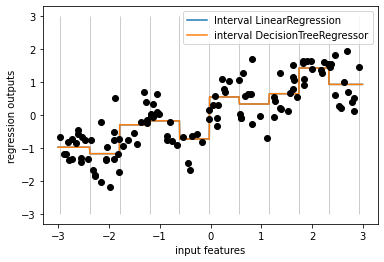

In [93]:
# 개념 설명을 위한 코드입니다.
# 아래에 출력된 그래프를 토대로 설명합니다.
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='Interval LinearRegression')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='interval DecisionTreeRegressor')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

위에서 출력했던 그래프입니다. 선형 모델은 wave 데이터셋의 각 구간에 대해 상숫값을 학습했습니다. 선형 모델은 이런 절편뿐만 아니라 기울기도 추가로 학습할 수 있습니다. 구간으로 분할된 데이터에 원래 특성(x축)을 다시 추가하여 선형 모델에 기울기를 추가할 수 있습니다. 이 방법을 사용하면 10차원에서 1차원이 더해져서 11차원이 됩니다. 이에 해당하는 그래프를 출력합니다.

In [94]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(120, 11)


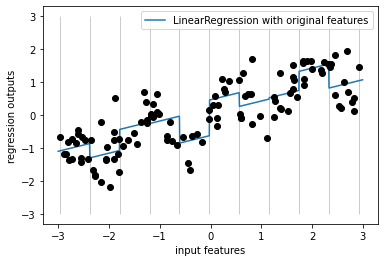

In [95]:
reg = LinearRegression().fit(X_combined, y)
line_combined = np.hstack([line, line_binned])

plt.plot(line, reg.predict(line_combined), label='LinearRegression with original features')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.plot(X[:, 0], y, 'o', c='k')
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

구간으로 분할된 특성과 기울기 하나를 사용한 선형 회귀 그래프를 출력했습니다. 위 코드에서 각 구간의 절편과 기울기를 학습했습니다. 기울기는 양수입니다. x축 특성이 하나이므로 모든 구간에서 취하는 기울기의 형태는 같습니다. 다만 결코 유익한 형태가 아닙니다. 각 구간에서 다른 기울기를 가지게 하는 게 좋습니다. 이를 위해 샘플이 있는 구간과 x축 사이의 '상호작용' 특성을 추가하는 방법을 사용할 수 있습니다. 상호작용 특성은 구간 특성과 원본 특성의 곱으로 이루어집니다. 아래 코드로 이러한 데이터셋을 만듭니다.

In [96]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(120, 20)


샘플이 속한 구간, 구간에 원본 특성을 곱한 값으로 이루어진 특성 20개를 가지게 되었습니다. 후자의 특성은 각 구간에 대한 x축 특성의 복사본으로 볼 수 있으며, 구간 안에서는 원본 특성이고 다른 곳에서는 0입니다. 'X_binned'는 샘플이 속한 구간의 원-핫-인코딩이므로 X를 곱하면 해당 구간 외에는 결국 0이 되는 것입니다. 

추가한 특성 20개를 토대로 선형 모델을 만듭니다.

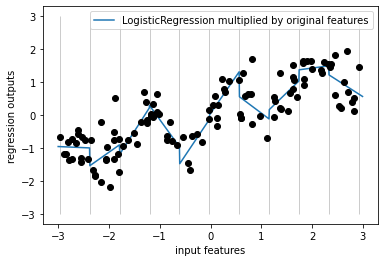

In [97]:
reg = LinearRegression().fit(X_product, y)
line_product = np.hstack([line_binned, line * line_binned])

plt.plot(line, reg.predict(line_product), label='LogisticRegression multiplied by original features')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.plot(X[:, 0], y, 'o', c='k')
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

절편과 기울기 모두 다른 형태입니다.

원본 특성의 다항식을 추가하는 방법도 있습니다. `PolynomialFeatures` 클래스에 이 방법이 구현되어 있습니다. 특성 x 가 주어지면 x ** 2, x ** 3, x ** 4 등을 만듭니다. 

In [98]:
from sklearn.preprocessing import PolynomialFeatures

# 고차항을 x ** 10까지 추가합니다.
# `include_bias=False`는 기본값을 지정한 매개변수입니다.
# 이를 통해 절편에 해당하는 1인 특성을 추가합니다.
# 'include_bias=True`로 지정하면 절편을 고려해서 특성 11개를 생성합니다.
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)
print(X_poly.shape)

(120, 10)


10차원을 지정했으므로 'x ** 1'부터 'x ** 10'까지 특성 10개가 만들어졌습니다. 

'X'와 'X_poly'의 값을 확인합니다.

In [99]:
print('X 원소:\n', X[:5])
print('X_poly 원소:\n', X_poly[:5])

X 원소:
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
X_poly 원소:
 [[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


각 특성의 차수를 담은 `get_feature_names` 메서드를 사용해서 특성의 의미를 확인합니다.

In [100]:
print('항 이름:\n', poly.get_feature_names())

항 이름:
 ['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


다항식 특성을 선형 모델과 함께 사용하면 '다항 회귀(polynomial regression)' 모델이 됩니다. 이 모델을 표현한 그래프를 출력합니다.

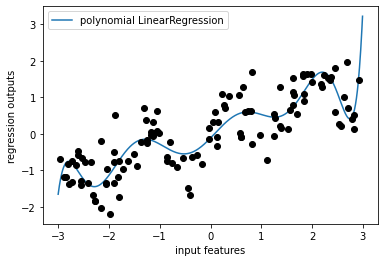

In [101]:
reg = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)

plt.plot(line, reg.predict(line_poly), label='polynomial LinearRegression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

다항식 특성은 1차원 데이터셋에서도 부드러운 곡선을 가집니다. 그러나 고차원 다항식은 데이터가 부족한 영역에서는 민감하게 동작합니다. 그래프의 시작점과 끝점에서 급격한 상승 곡선과 하락 곡선 형태를 띱니다.

비교를 위해 원본 데이터에 커널 SVM 모델을 학습시켜서 확인합니다.

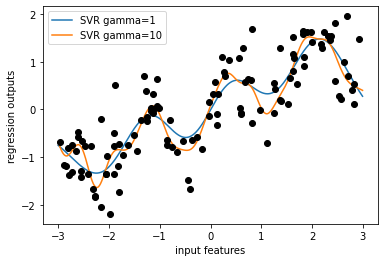

In [102]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

더 복잡한 모델인 커널 SVM을 사용해서 특성 데이터를 변환하지 않고 다항 회귀와 비슷한 복잡도를 가진 예측을 만들었습니다.

보스턴 주택 가격 데이터셋을 이용해서 상호작용과 다항식에 대해 더 살핍니다. 먼저 데이터셋을 읽어 들여서 `MinMaxSCaler` 클래스를 사용하여 0에서 1로 스케일을 조정합니다.

In [103]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

차수를 2로 지정해서 다항식 특성을 뽑습니다.

In [104]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print('X_train.shape:', X_train.shape)
print('X_train_poly.shape:', X_train_poly.shape)

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


특성 13개에서 교차 특성 105개로 확장됐습니다. 확장된 특성들은 원본 특성에 대한 제곱, 가능한 두 특성의 조합 모두를 가집니다. `dgree=2`로 지정하면 원본 특성에서 두 개를 뽑아서 만들 수 있는 모든 곱을 얻습니다.

참고로 `degree=3`으로 지정하면 원본 특성, 중복을 허용하여 두 개를 뽑아 만든 곱의 항, 중복을 허용하여 세 개를 뽑아 만든 곱의 항이 만들어집니다. 1(절편) + 13(원본 특성) + 91(두 개 조합) + 455(세 개 조합) = 560개만큼 특성이 생성됩니다. `interaction_only=Ture`로 지정하면 거듭제곱이 포함된 항은 모두 제거됩니다.

`get_feature_names` 메서드를 사용하면 어떤 원본 특성이 곱해져서 새로운 특성이 생성됐는지 확인할 수 있습니다.

In [105]:
print('다항 특성의 이름:\n', poly.get_feature_names())

다항 특성의 이름:
 ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


첫 번째 특성은 상수항(1)입니다. 다음 특성 13개는 원본 특성입니다. 그다음부터는 첫 번째 특성의 제곱항과 첫 번째 특성과 다른 특성의 조합입니다.

상호작용 특성을 가진 데이터와 가지지 않은 데이터에 `Ridge`를 사용해서 성능을 비교합니다.

In [106]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train_scaled, y_train)
print('상호작용 특성이 없을 때 점수: {:.3f}'.format(ridge.score(X_test_scaled, y_test)))

ridge = Ridge().fit(X_train_poly, y_train)
print('상호작용 특성이 있을 때 점수: {:.3f}'.format(ridge.score(X_test_poly, y_test)))

상호작용 특성이 없을 때 점수: 0.577
상호작용 특성이 있을 때 점수: 0.741


상호작용 특성과 다항식 특성이 성능을 크게 높였습니다. 다만 랜덤 포레스트처럼 더 복잡한 모델을 사용하면 성능이 조금 줄어듭니다. 이를 확인합니다.

In [107]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_scaled, y_train)
print('상호작용 특성이 없을 때 점수: {:.3f}'.format(rf.score(X_test_scaled, y_test)))

rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_poly, y_train)
print('상호작용 특성이 있을 때 점수: {:.3f}'.format(rf.score(X_test_poly, y_test)))

상호작용 특성이 없을 때 점수: 0.786
상호작용 특성이 있을 때 점수: 0.761


오히려 성능이 떨어진 것을 확인할 수 있습니다. `RandomForestRegressor`(원본 특성)는 `Ridge`(상호작용 특성)와 성능이 비슷합니다.

# 4.6 일변량 비선형 변환

특성 변환에는 log, exp, sin 같은 수학 함수를 적용해도 좋습니다. 트리 기반 모델은 특성 순서에만 영향을 받지만, 선형 모델과 신경망은 각 특성의 스케일과 분포에 밀접한 연관성을 가집니다. 아울러 특성과 타깃값 사이에 비선형성이 존재한다면 선형 회귀에서는 모델을 만들기 어렵습니다. log와 exp 함수는 데이터 스케일을 변경해서 선형 모델과 신경망의 성능을 제고하는 데 도움이 됩니다. sin과 cos 함수는 주기적인 패턴이 있는 데이터를 다룰 때 편리합니다.

모델 대부분은 각 특성이 정규분포와 비슷할 경우에(회귀는 타깃도 비슷할 경우에) 최대 성능을 가집니다(확률적 요소를 가진 많은 알고리즘 이론이 정규분포를 근간으로 합니다). 특성의 히스토그램이 종 모양과 비슷한 경우를 의미합니다. log나 exp 같은 함수를 사용하는 것은 편법입니다. 그러나 효과적인 방법입니다. 특히 음수가 없고 특별한 통계 패턴을 따르는 정수 카운트를 다룰 때 그렇습니다. 카운트 데이터의 예는 '사용자가 자주 로그인 하는 횟수' 같은 특성입니다.

참고로 트리 기반 모델의 `max_features` 매개변수는 트리의 각 분기에서 사용될 후보 특성의 개수를 제한합니다. 랜덤 포레스트의 `max_features` 매개변수 기본값(`auto`)은 특성 개수의 제곱근을 나타냅니다. 이는 특성의 나열 순서가 결과에 영향을 줄 수 있습니다. 결정 트리와 그레이디언트 부스팅 트리의 기본값(`None`)은 전체 특성을 사용합니다. 하지만 `max_features='auto'`로 설정하면 랜덤 포레스트처럼 특성의 나열 순서에 영향을 받을 수 있습니다.

실제 데이터의 속성과 비슷한 카운트 데이터를 만들어서 사용합니다. 특성은 모두 정수이며, 응답은 실수입니다.

In [108]:
rnd = np.random.RandomState(0)
# `normal()` 메서드는 정규(가우시안) 분포를 의미합니다.
X_org = rnd.normal(size=(1000, 3))
print('X_org:\n', X_org)
w = rnd.normal(size=3)
print('w:', w)
print()
# 'poisson()` 메서드는 푸아송 분포를 의미합니다.
# 푸아송 분포는 단위 시간 안에 일어날 이벤트 횟수를 나타내는 확률 분포입니다.
# `numpy.exp()` 함수는 밑이 자연상수 e인 지수함수(e^x)로 변환합니다.
X = rnd.poisson(10 * np.exp(X_org))
print('X:\n', X)
y = np.dot(X_org, w)
# y는 출력값이 많으므로 주석 처리 합니다.
# print('y:', y)
print(X[:10, 0])

X_org:
 [[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 ...
 [-1.30322008  0.46675065  0.16110632]
 [ 0.32003193  2.07917666 -0.90746598]
 [-0.19240421 -1.21251574 -0.08059852]]
w: [ 1.59327362  0.5687224  -0.11448705]

X:
 [[56 18 27]
 [81 57  3]
 [25  9 11]
 ...
 [ 2 16 16]
 [ 7 76  4]
 [ 7  3  8]]
[ 56  81  25  20  27  18  12  21 109   7]


첫 번째 특성 맨 앞 10개를 살폈습니다. 모두 양의 정수이지만 패턴은 없습니다.

이번엔 값의 개수를 세겠습니다.

In [109]:
# 0부터 시작하는 `bincount()` 함수를 사용합니다.
print('특성 출현 횟수:\n', np.bincount(X[:, 0]))

특성 출현 횟수:
 [28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


가장 많이 나타난 값은 2(68번)입니다. 큰 값의 수는 빠르게 줄어드는 경향을 보입니다. 

위의 값들을 그래프로 출력합니다.

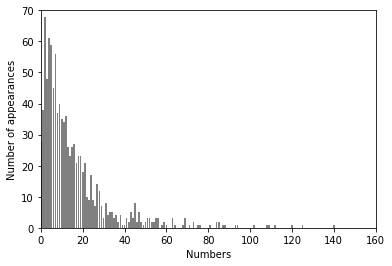

In [110]:
plt.xlim(0, 160)
plt.ylim(0, 70)
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='grey')
plt.xlabel('Numbers')
plt.ylabel('Number of appearances')
plt.show() 

'X[:, 1]'과 'X[:, 2]' 특성도 비슷합니다. 이런 분포는 자주 있습니다. 다만 선형 모델은 잘 처리하지 못하는 형태입니다.

참고로 카운트 데이터의 전형적인 분포는 푸아송 분포입니다. 

이 데이터에 `Ridge`를 적용합니다.

In [111]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print('테스트 점수: {:.3f}'.format(score))

테스트 점수: 0.622


다소 낮은 $R^2$ 점수가 출력됐습니다. 이는 `Ridge` 클래스가 X와 y의 관계를 제대로 모델링 하지 못했다는 것을 의미합니다. 여기에 로그 스케일로 변환하면 도움이 될 것입니다.

로그 스케일로 변환하기 위해 데이터에 log 함수를 적용합니다. 데이터에 0이 있으면 log 함수를 적용할 수 없습니다(로그 0은 정의할 수 없습니다). `np.log(0)`은 음의 무한대로 -inf를 반환합니다. 고로 log(X+1)을 채택합니다. 

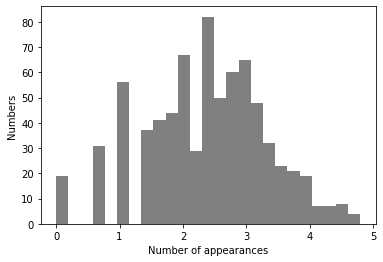

In [112]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

plt.hist(X_train_log[:, 0], bins=25, color='gray')
plt.xlabel('Number of appearances')
plt.ylabel('Numbers')
plt.show()

로그 형태로 변환 후의 'X[0]' 특성 값의 히스토그램입니다. 데이터 분포가 덜 치우치게 됐습니다. 매우 큰 값을 가진 이상치 또한 없습니다.

`Ridge` 클래스에 적용합니다.

In [113]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print('테스트 점수: {:.3f}'.format(score))

테스트 점수: 0.875


위에서 출력했던 결과보다 훨씬 좋은 점수입니다.

데이터셋과 모델 조합에 최적인 변환 방법을 찾는 일은 결코 쉽지 않습니다. 이 예에서는 모든 특성이 같은 속성을 가졌지만 실전에서는 이런 경우는 드뭅니다. 일부 특성만 변환하거나 특성마다 다르게 변환합니다. 다시 강조하지만 이러한 과정은 선형 모델에서만 필수입니다. 트리 모델은 필요없는 과정입니다.

회귀에서는 타깃 변수 y를 변환하면 좋을 수도 있습니다. 카운트를 예측하는 경우는 전형적인 예입니다. log(y+1)를 사용해서 변환하면 됩니다.

참고로 SVM, 최근접 이웃, 신경망 같은 모델은 구간 분할, 상호작용, 다항식으로 약간의 이점을 취할 수는 있지만 선형 모델보다는 적은 영향을 받습니다. 

# 4.7 특성 자동 선택

특성이 추가되면 모델은 더 복잡해지고 과대적합될 가능성도 높아집니다. 보통 새로운 특성을 추가할 때나 고차원 데이터셋을 사용할 때, 모델을 간단하게 만들고 일반화 성능을 높이기 위해서는 가장 유용한 특성만 선택하고 나머지는 무시해서 불필요한 특성의 수를 줄이는 것이 좋습니다. 어떤 특성이 좋은지 알 수 있는 방법은 '일변량 통계(univariate)', '모델 기반 선택(model-based selection)', '반복적 선택(iterative selection)'입니다. 이 세 가지 모두 지도학습 방법입니다. 지도학습에서는 최적값을 찾으려면 타깃값이 필요합니다. 그리고 훈련 데이터만으로 특성을 선택하는 데에 사용해야 합니다. 이는 테스트 세트 정보가 누설되는 것을 막을 목적으로 하는 과정입니다. 정보누설에 대한 설명은 6장에서 서술합니다. 개념에 대한 이해는 미루고 일단 넘어가도 좋습니다.

## 4.7.1 일변량 통계

일변량 통계에서는 각각 특성과 타깃 사이에 중요한 통계적 관계가 있는지 계산합니다. 계산을 마치면 깊게 관련된다고 판단되는 특성을 선택합니다. 분류에서는 '분산분석(ANOVA, analysis of variance)'이라고도 부릅니다. 데이터를 클래스별로 나눠서 평균을 비교하는 방법입니다. 분산분석으로 계산한 어떤 특성의 F-값이 높으면 그 특성은 클래스별 평균이 서로 다르다는 것을 의미합니다. 분산분석과 관련된 핵심 요소는 일변량입니다. 각 특성이 독립적으로 평가되는 것을 의미하며, 다른 특성과 깊게 연관된 특성은 선택되지 않습니다. 일변량 분석은 계산이 매우 빠르고 평가를 목적으로 모델을 생성하지 않아도 됩니다. 더욱이 이 방식은 적용하려는 모델과는 상관없이 사용할 수 있습니다.

일변량 분석으로 특성을 선택하려면 분류에서는 클래스가 가진 매개변수의 기본값인 `f_classif`를, 회귀에서는 `f_regression`을 통해 테스트합니다. 계산한 $p-$ 값($p-$value)에 기초하여 특성을 제외합니다. 여기에서 매우 높은 $p-$값을 가진 특성을 제외하도록 임계값을 조정하는 매개변수를 사용합니다.

임계값을 계산하는 방법은 각각 다릅니다. 가장 간단한 방법은 `SelectKBest`와 `SelectPercentile`입니다. `SelectKBest`는 고정된 k개의 특성을 선택하고, `SelectPercentile`은 지정된 비율만큼 특성을 선택합니다.

참고로 분류인 `f_classif`에서는 클래스별 평균의 분산($SS_{between}$)을 전체 분산($SS_{tot}$)에서 클래스별 평균 분산($SS_{between}$)을 뺀 값으로 나누어 F-값을 계산합니다. 클래스가 k개이고 샘플이 n개일 경우를 식으로 나타내면 $F=\frac{SS_{between}/(k-1)}{(SS_{tot}-SS_{between})/(n-k)}$이고, $SS_{between}=\displaystyle\sum_{j=1}^{k} n_j(\overline{x_j}-\overline{x})^2$, $SS_{tot}=\displaystyle\sum_{j=1}^{k} n_j(\overline{x_i}-\overline{x})^2$입니다. 사이킷런에서는 계산 속도를 높이기 위해 이 식에서 유도된 간소화된 식을 사용해서 계산합니다. [링크](https://goo.gl/9NvAoQ)를 참고하기 바랍니다.

아울러 회귀인 `f_regression`에서는 각 특성에 대해 상관계수 $Corr=\frac{\displaystyle\sum_{i=1}^{n}(\overline{x_i}-\overline{x})(\overline{y_i}-\overline{y})}{std(x)std(y)}$를 계산하고, 이를 이용해서 F- 값과 $p-$ 값을 계산합니다. 분류에서 사용할 수 있는 옵션으로 카이 제곱(Chi-squared) 함수인 `chi2`도 있습니다.

클래스들의 평균이 같다는 가설을 세울 때 $p-$ 값은 이 가설을 지지하는 확률을 나타냅니다. F-분포에서는 F- 값 이후의 오른쪽 꼬리 부분의 면적이고 `pvalues_` 속성에 저장됩니다. `pvalues_` 값이 큰 특성은 클래스들의 평균이 비슷하므로 타깃에 미치는 영향이 적다고 판단합니다.

사이킷런의 `SelectKBest`, `SelectPercentile`에서 특성을 선택하는 기준은 F- 값(`scores_` 속성에 저장됩니다)입니다. 이 값이 클수록 클래스 평균의 분산이 비교적 크다는 것을 의미합니다. 

cancer 데이터셋에 분류를 위한 특성 자동 선택(이하 특성 선택)을 적용합니다. 특성 선택이 불필요한 특성을 제거하는지 알아볼 목적으로 데이터셋에 의미 없는 노이즈 특성을 추가합니다.

In [114]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
# 고정된 난수를 발생시킵니다.
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# 데이터에 노이즈 특성을 추가합니다.
# 처음 30개는 원본 특성, 다음 50개까지는 노이즈 특성입니다.
X_w_noise = np.hstack([cancer.data, noise])
X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# `SelectPercentile` 클래스를 사용하여 특성의 50%를 선택합니다.
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)
# 훈련 세트에 적용합니다.
X_train_selected = select.transform(X_train)
print('X_train.shape:', X_train.shape)
print('X_train_selected.shape:', X_train_selected.shape)

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


특성 개수가 80개에서 40개로 줄었습니다. 특성 선택은 `fit`메서드에서 훈련 세트로 통곗값을 계산하고 `transform` 메서드에서 훈련 세트와 테스트 세트의 특성을 선택합니다.

`get_support` 메서드는 선택된 특성을 불리언 값으로 표시합니다. 이를 통해 `SelectPercentile` 클래스가 어떤 특성을 선택했는지 확인할 수 있습니다.

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


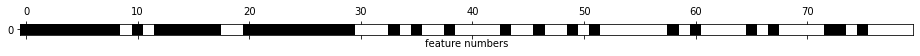

In [115]:
 mask = select.get_support()
 print(mask)
 # True는 검은색, False는 흰색으로 지정합니다.
 plt.matshow(mask.reshape(1, -1), cmap='gray_r')
 plt.xlabel('feature numbers')
 plt.yticks([0])
 plt.show()

선택된 특성은 대부분 원본 특성이고, 노이즈 특성은 대부분 선택되지 않았습니다. 그렇다고 모든 원본 특성이 복원되지는 않았습니다. 

전체 특성을 이용했을 경우와 선택된 특성만 사용했을 경우 로지스틱 회귀의 성능을 확인합니다.

In [116]:
from sklearn.linear_model import LogisticRegression

# 테스트 데이터를 변환합니다.
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
print('전체 특성을 사용한 점수: {:.3f}'.format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print('선택된 특성을 사용한 점수: {:3f}'.format(lr.score(X_test_selected, y_test)))

전체 특성을 사용한 점수: 0.951
선택된 특성을 사용한 점수: 0.933333


책의 결과(전체 특성 점수: 0.930, 선택 특성 점수: 0.940)와 다릅니다. 책에서는 노이즈 특성을 제거한 쪽의 성능이 더 높지만 크게 중요한 지점은 아닙니다. 인위적으로 만든 예제일 뿐이며, 실전에서는 엇갈리는 경우도 많습니다. 하지만 너무 많은 특성 때문에 모델을 생성하기가 어려운 경우에는 일변량 분석을 통해 특성을 선택하면 큰 도움이 됩니다. 기존에 존재하는 많은 특성이 도움이 안 된다는 판단이 들 때도 일변량 분석은 큰 도움이 됩니다.

## 4.7.2 모델 기반 특성 선택

'모델 기반 특성 선택'은 지도 학습 머신러닝 모델을 토대로 특성 중요도를 평가해서 가장 중요한 특성들만 선택합니다. 특성 선택에 사용하는 지도 학습 모델은 최종적으로 사용할 지도 학습 모델과 동일할 필요는 없습니다.

특성 선택을 위한 모델은 각 특성의 중요도를 측정해서 순서를 매길 수 있어야 합니다. 결정 트리와 이를 기반으로 한 모델은 각 특성의 중요도가 담겨 있는 `feature_importances_` 속성을 제공합니다. 물론 선형 모델 계수의 절댓값도 특성의 중요도를 재는 데 사용할 수 있습니다.

L1 규제를 사용한 선형 모델은 일부 특성의 계수만 학습합니다. 이는 그 모델 자체를 위해 특성이 선택된다고 여길 수 있지만, 다른 모델의 특성 선택을 위해 전처리 단계로도 사용할 수  있습니다. 일변량 분석과는 달리 모델 기반 특성 선택은 한 번에 모든 특성을 고려합니다. 사용된 모델이 상호작용을 잡아낼 수만 있다면 상호작용 부분을 반영할 수 있습니다. 모델 기반 특성 선택은 `SelectFromModel` 클래스에 구현되어 있습니다.

In [117]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                         threshold='median')

`SelectFromModel` 클래스는 지도 학습 모델로 계산된 중요도가 지정한 임계치보다 큰 모든 특성을 선택합니다. 일변량 분석으로 선택한 결과를 비교하기 위해 절반 가량의 특성이 선택될 수 있도록 중간값을 임계치로 사용하겠습니다. 트리 100개로 만든 랜덤 포레스트 분류기를 사용하여 특성 중요도를 계산합니다. 이는 매우 복잡한 모델이고, 일변량 분석보다는 훨씬 강력합니다. 이 모델을 만듭니다.

In [118]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print('X_train.shape:', X_train.shape)
print('X_train_l1.shape:', X_train_l1.shape)

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


선택된 특성을 위와 같은 방식으로 그립니다.

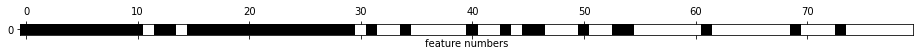

In [119]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('feature numbers')
plt.yticks([0])
plt.show()

`RandomForestClassifier` 클래스를 사용한 `SelectFromModel` 클래스가 선택한 특성을 나타낸 그래프입니다. 두 개를 제외한 모든 원본 특성이 선택되었습니다. 인덱스가 0부터 시작하므로 29까지가 원본 특성입니다. 특성 40개를 선택하도록 지정했으므로 일부 노이즈 특성도 선택됐습니다.

성능을 확인합니다.

In [120]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=5000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print('테스트 점수: {:3f}'.format(score))

테스트 점수: 0.947368


특성 선택이 더 잘 이루어졌으므로 일변량 통계에서의 성능보다 성능이 더 향상됐습니다.

## 4.7.3 반복적 특성 선택

일변량 분석에서는 모델을 사용하지 않았고, 모델 기반 선택에서는 모델 하나를 사용해서 특성을 선택했습니다. '반복적 특성 선택(iterative Feature Selection)'에서는 특성 수가 각기 다른 일련의 모델이 생성됩니다.

방법은 두 가지입니다. 첫 번째 방법은 특성을 하나도 선택하지 않은 상태로 시작해서 특정 종료 조건에 도달할 때까지 하나씩 추가하는 '전진 선택법(forward stepwise selection)'과 '후진 선택법(backward stepwise selection)'입니다. `SequentialFeatureSelector` 클래스는 `scoring` 매개변수에 지정된 측정 지표의 교차 검증 점수를 기준으로 특성을 하나씩 추가하거나 제거합니다. 기본값은 분류일 경우에는 정확도, 회귀일 경우에는 $R^2$입니다. `direction` 매개변수의 기본값은 전진 선택법을 의미하는 값인 `forward`이고, 후진 선택법을 의미하는 값은 `backward`입니다.

두 번째 방법은 모든 특성을 가지고 시작해서 특정 종료 조건에 도달할 때까지 특성을 하나씩 제거하는 방법입니다. 일련의 모델이 만들어지므로 앞에서 제시한 방법들보다 계산 비용이 훨씬 많이 듭니다.

이 방법 중에 한 가지는 '재귀적 특성 제거(`RFE`, recursive feature elimination)'입니다. 모든 특성으로 시작해서 모델을 만들고, 특성 중요도가 가장 낮은 특성을 제거합니다. 그 다음에 나머지 특성 전체로 모델을 새로 만듭니다. 이런 방식으로 미리 정의한 특성 개수가 남을 때까지 지속합니다. 이를 위해 모델 기반 선택에서처럼 특성 선택에 사용할 모델은 특성 중요도를 결정하는 방법을 지정해야 합니다.

랜덤 포레스트 모델을 사용해서 선택된 특성에 대한 그래프를 그립니다.

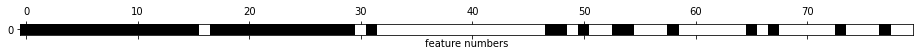

In [121]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)
select.fit(X_train, y_train)
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('feature numbers')
plt.yticks([0])
plt.show()

일변량 분석이나 모델 기반 선택보다 특성 선택이 나아졌지만 여전히 특성 한 개는 놓쳤습니다. 랜덤 포레스트 모델은 특성이 누락될 때마다 다시 학습하므로 40번만큼 실행됩니다. 따라서 셀 처리 시간이 오래 걸리는 것입니다. 

`RFE` 클래스를 사용해서 특성을 선택했을 경우에 로지스틱 회귀의 정확도를 확인합니다. 

In [122]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)
score = LogisticRegression(max_iter=5000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print('테스트 점수: {:.3f}'.format(score))

테스트 점수: 0.940


`RFE`에 사용된 모델을 이용해서도 예측할 수 있습니다. 선택된 특성만 사용됩니다.

In [123]:
print('테스트 점수: {:3f}'.format(select.score(X_test, y_test)))

테스트 점수: 0.950877


`RFE` 안에 있는 랜덤 포레스트의 성능이 이 모델에서 선택한 특성을 만든 로지스틱 회귀의 성능과 다릅니다. 오히려 랜덤 포레스트의 성능보다 로지스틱 회귀의 성능이 더 높습니다. 서적의 내용과는 다른 결과입니다. 원인은 파악하지 못했습니다.

머신러닝 알고리즘에 어떤 입력값을 넣을지 확신이 서지 않는다면 특성 자동 선택이 도움이 될 수 있습니다. 아울러 예측 속도를 높이거나 해석하기 더 쉬운 모델을 만들 때 특성을 필요한 만큼 줄이는 점에 있어서도 효과적입니다. 물론 실전에서는 대부분 특성 선택이 큰 성능 향상을 끌어내진 못합니다.

# 4.8 전문가 지식 활용

전문가의 사전 지식은 초기에 데이터에서 더 유용한 특성을 선택할 수 있도록 도움을 줍니다.

여행사를 위해 항공료를 예측한다고 가정합니다. 날짜, 항공사, 출발지, 도착지, 항공료를 기록할 수 있을 것입니다. 이 데이터에서 바로 머신러닝 모델을 생성할 수 있지만, 예컨대 항공료에 포함된 주요한 요소(휴가 성수기, 공휴일 근처, 음력 공휴일, 기관 지정 공휴일 등에 항공료가 비싸지는 경향)는 학습시키기 어렵습니다. 이 요소에 대하여 데이터에 기록된 날짜만 사용해서는 학습되기 어려운 것입니다.

다만 사전 지식이 있다면 공휴일과 방학 전후의 비행 스케줄이 기록된 특성을 추가하여 모델을 학습시킬 수 있습니다. 물론 공휴일 정보가 항공료 예측에 도움이 되지 않는다고 판단되더라도, 해당 특성을 추가했을 때 머신러닝 알고리즘이 그 특성을 꼭 사용하는 것은 아닙니다. 이 정보를 데이터에 추가하는 것은 전혀 문제가 되지는 않습니다. 

전문가 지식을 활용하는 사례 하나를 살핍니다. 집 앞의 자전거를 대여할 수 있는지 예측하는 일입니다. 특정 날짜와 시간에 집 앞에 있는 자전거를 사람들이 얼마나 대여할지 예측하고자 합니다. [자전거 대여 데이터](https://www.citibikenyc.com/system-data)는 익명으로 공개되어 있습니다. 이 대여소에 대한 2015년 8월 데이터를 판다스의 데이터프레임으로 읽습니다. 그리고 세 시간 간격으로 데이터를 나눠서 하루간 주요 경향을 살핍니다.

In [124]:
citibike = mglearn.datasets.load_citibike()
print('시티 바이크 데이터:\n', citibike.head())

시티 바이크 데이터:
 starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


3시간마다 자전거가 대여된 횟수를 저장한 열인 one을 추가하여 1로 채워서 `resample` 메서드를 사용하고, 3시간마다 누적한 형태를 취합니다. `load_citibike` 함수는 이 열을 출력합니다.

8월 한 달간 대여 횟수를 그래프로 나타냅니다. 함수 [pd.date_range](https://workingwithpython.com/date_range/)에 대한 설명을 참조 바랍니다.

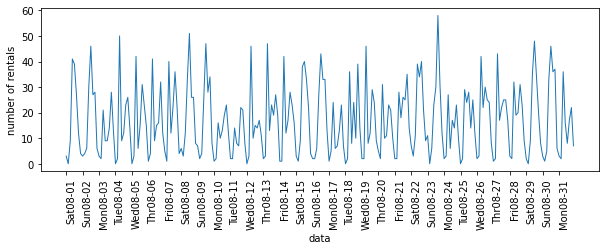

In [128]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat']
xticks_name = [week[int(w)]+d for w, d in zip(xticks.strftime('%w'),
                                              xticks.strftime('%m-%d'))]
plt.xticks(xticks, xticks_name, rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel('data')
plt.ylabel('number of rentals')
plt.show()

# 4.9 요약 및 정리